### Get Image from RealsenseD435i

#### Utility Functions

In [39]:
import json
import pyrealsense2 as rs
import matplotlib.pyplot as plt
import numpy as np
import mujoco
import mujoco_viewer
import cv2,os
import sys
sys.path.append('../')
""" FOR MuJoCo """
from models.utils.util import  *
from models.env.manipulator_agent import ManipulatorAgent
""" FOR ONROBOT RG2 """
from pymodbus.client.sync import ModbusTcpClient  
""" FOR MODERN DRIVER """
import roslib; roslib.load_manifest('ur_driver')
import rospy
""" FOR UR5 """
from models.realrobot.gripper import openGrasp, closeGrasp, resetTool
from models.realrobot.RealRobot import RealRobot
from control_msgs.msg import *
from trajectory_msgs.msg import *
from sensor_msgs.msg import JointState

def compute_xyz(depth_img, camera_info):

    # x, fy, px, py
    fx = camera_info[0]
    fy = camera_info[1]
    cx = camera_info[2]
    cy = camera_info[3]

    height = depth_img.shape[0]
    width = depth_img.shape[1]

    indices = np.indices((height, width), dtype=np.float32).transpose(1, 2, 0)
    
    z_e = depth_img * 0.001 # Convert to meters
    x_e = (indices[..., 1] - cx) * z_e / fx 
    y_e = (indices[..., 0] - cy) * z_e / fy
    
    # Order of y_ e is reversed !
    xyz_img = np.stack([z_e, -x_e, -y_e], axis=-1) # [H x W x 3] 
    return xyz_img

Intrinsic matrix: 
[[907.66796875   0.         638.40039062]
 [  0.         907.62683105 356.03598022]
 [  0.           0.           1.        ]]


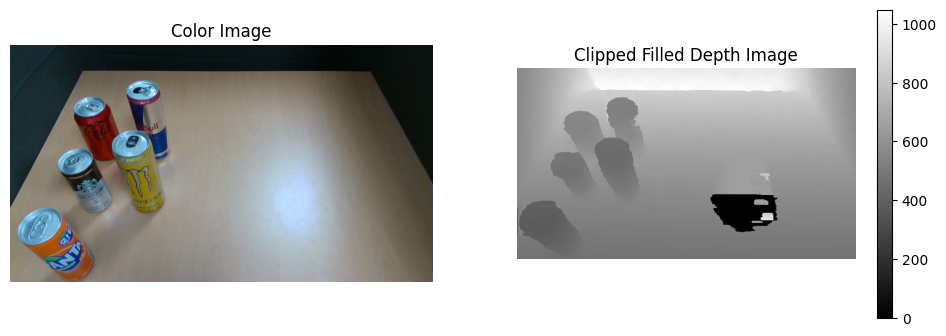

In [200]:
# Load camera settings
jsonObj = json.load(open("./cam_setting.json"))
stream_width = int(jsonObj["viewer"]['stream-width'])
stream_height = int(jsonObj["viewer"]['stream-height'])
stream_fps = int(jsonObj["viewer"]['stream-fps'])

# Configure pipeline
pipe = rs.pipeline()
cfg = rs.config()
cfg.enable_stream(rs.stream.depth, stream_width, stream_height, rs.format.z16, stream_fps)
cfg.enable_stream(rs.stream.color, stream_width, stream_height, rs.format.bgr8, stream_fps)
pipe.start(cfg)
profile = pipe.get_active_profile()
# intrinsics = profile.get_stream(rs.stream.depth).as_video_stream_profile().get_intrinsics()
intrinsics = profile.get_stream(rs.stream.color).as_video_stream_profile().get_intrinsics()

# Create the intrinsic matrix
K = np.array([[intrinsics.fx, 0, intrinsics.ppx],
              [0, intrinsics.fy, intrinsics.ppy],
              [0, 0, 1]])
camera_info = [intrinsics.fx, intrinsics.fy, intrinsics.ppx, intrinsics.ppy]
print(f"Intrinsic matrix: \n{K}")

# Capture frames
for _ in range(100):
    pipe.wait_for_frames()

# Retrieve frames
frameset = pipe.wait_for_frames()
aligned_frames = rs.align(rs.stream.color).process(frameset)
depth_frame = aligned_frames.get_depth_frame()
color_frame = aligned_frames.get_color_frame()

# Apply depth filters
spatial = rs.spatial_filter()
spatial.set_option(rs.option.holes_fill, 3)
hole_filling = rs.hole_filling_filter()

# Get RGBD images
depth_image = np.asanyarray(hole_filling.process(spatial.process(depth_frame)).get_data())
depth_image_unfilled = np.asanyarray(depth_frame.get_data())
rgb_image = np.asanyarray(color_frame.get_data())
rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)
# Clip depth image
depth_scale = pipe.get_active_profile().get_device().first_depth_sensor().get_depth_scale()
clipping_distance_in_meters = 2
clipping_distance = clipping_distance_in_meters / depth_scale
depth_unfilled_clipped = np.where((depth_image_unfilled > clipping_distance) | (depth_image_unfilled <= 0), 0, depth_image_unfilled)
depth_clipped = np.where((depth_image > clipping_distance) | (depth_image <= 0), 0, depth_image)
# Cleanup
pipe.stop()

# Display images
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title("Color Image")
# plt.imshow(depth_unfilled_clipped, cmap='gray')
plt.imshow(rgb_image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Clipped Filled Depth Image")
plt.imshow(depth_clipped, cmap='gray')
plt.colorbar()
plt.axis('off')
plt.show()

In [201]:
import os
import numpy as np

save_dir = "./images/"
# folder_dir = "./color/"
# folder_dir = "./type/"
# folder_dir = "./shape/"
# folder_dir = "./vertical/"
# folder_dir = "./horizontal/"
# folder_dir = "./diagonal/"

folder_dir = "./quadrant/"
if not os.path.exists(save_dir+folder_dir):
    os.makedirs(save_dir+folder_dir)
if not os.path.exists(save_dir+folder_dir+'./depth/'):
    os.makedirs(save_dir+folder_dir+'./depth/')
    
# Save images
image_name = len(os.listdir(save_dir+folder_dir)) - 2
rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2BGR)
cv2.imwrite(save_dir + folder_dir + f'{image_name}' + ".png", rgb_image)
# save depth image
np.save(save_dir + folder_dir + './depth/' + f'{image_name}' + ".npy", depth_clipped)

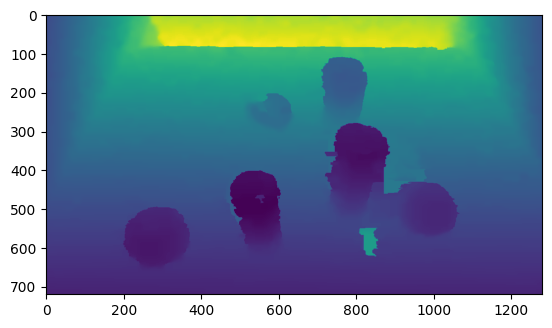

In [51]:
plt.imshow(np.load(save_dir + folder_dir + './depth/' + f'{image_name}' + ".npy"))
plt.show()

In [3]:
np.rad2deg(np.array([-1.1693690458880823, -2.1257835827269496, 2.4137819449054163, 0.9681593614765625, 0.9362161159515381, -1.068995777760641]))

array([ -66.99991102, -121.79842745,  138.29951811,   55.47144531,
         53.64123216,  -61.24894638])

Shape of xyz_img: (720, 1280, 3)


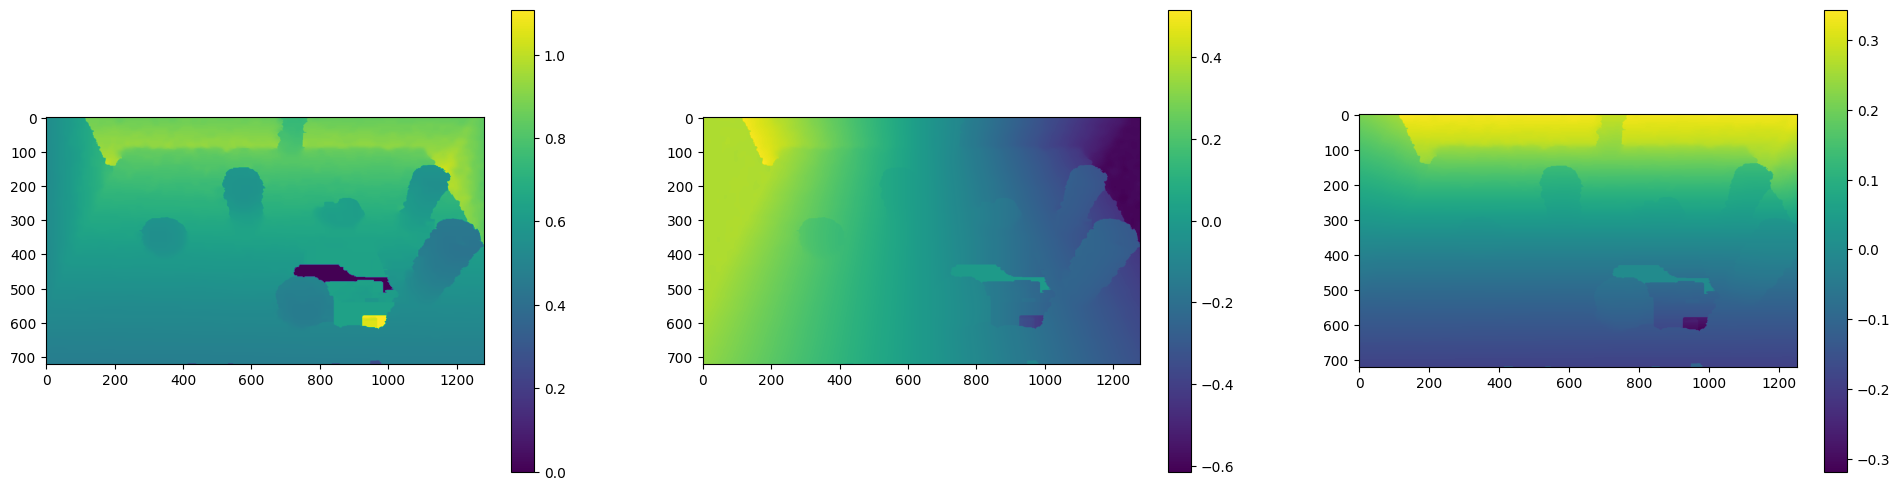

In [3]:
# camera_info = [636.6062622070312, 636.6062622070312, 645.9668579101562, 360.9885559082031]
xyz_img = compute_xyz(depth_clipped, camera_info=camera_info)
xyz_unfilled_img = compute_xyz(depth_unfilled_clipped, camera_info=camera_info)
print(f"Shape of xyz_img: {xyz_img.shape}")

plt.figure(figsize=(24, 6))
plt.subplot(1, 3, 1)
plt.imshow(xyz_img[:,:,0])
plt.colorbar()
# plt.show()
plt.subplot(1, 3, 2)
plt.imshow(xyz_img[:,:,1])
plt.colorbar()
# plt.show()
plt.subplot(1, 3, 3)
plt.imshow(xyz_img[:,:,2][:,:-30])
plt.colorbar()
plt.show()

#### Instantiate Real UR robot and open Gripper

In [4]:
rospy.init_node('Pick_n_Place')
real_robot = RealRobot()
graspclient = ModbusTcpClient('192.168.0.4') 
resetTool(graspclient)
openGrasp(force=200, width=1000, graspclient=graspclient)

Tool reseting


In [5]:
print(real_robot.joint_list.position)
joint_value = real_robot.joint_list.position

(-1.170938793812887, -2.1280881367125453, 2.416511360798971, 0.9670821863361816, 0.9350063800811768, -1.0703499952899378)


In [7]:
joint_value = (-1.170938793812887, -2.1280881367125453, 2.416511360798971, 0.9670821863361816, 0.9350063800811768, -1.0703499952899378)

#### Sync with MuJoCo

In [4]:
xml_path = '../asset/ur5e/realworld.xml'
MODE = 'window' ################### 'window' or 'offscreen'
env = ManipulatorAgent(rel_xml_path=xml_path,VERBOSE=False, MODE=MODE)
env.close_viewer()

MODE: window


In [5]:
# Move tables and robot base
env.model.body('base_table').pos = np.array([0,0,0.395])
env.model.body('front_object_table').pos = np.array([-38+0.6,-80,0])
env.model.body('side_object_table').pos = np.array([-0.38-2.4,0,0])
env.model.body('side_short_object_table').pos = np.array([0.38+0.4,0,0])

env.model.body('ur_base').pos = np.array([0.18,0,0.79])
for body_name in ['base_table','front_object_table','side_object_table']:
    geomadr = env.model.body(body_name).geomadr[0]
    env.model.geom(geomadr).rgba[3] = 1.0

env.close_viewer()
print ("Ready.")

Ready.


In [8]:
xyz_img = compute_xyz(depth_clipped, camera_info=camera_info)
print(f"Shape of xyz_img: {xyz_img.shape}")

rsz_rate = 25
if rsz_rate is not None:
    h_rsz,w_rsz = depth_clipped.shape[0]//rsz_rate,depth_clipped.shape[1]//rsz_rate
    xyz_img_rsz = cv2.resize(xyz_img,(w_rsz,h_rsz),interpolation=cv2.INTER_NEAREST)

env.forward(q=joint_value, joint_idxs=env.idxs_forward)
p_cam, R_cam = env.get_pR_body('ur_camera_center')
p_cam = env.get_p_body("ur_camera_center") + np.array([-0.0, 0.05,0.025])
R_world = env.get_R_body('ur_camera_center')
rotation_mat = np.eye(4)
Transform_rel = rpy2r(np.array([0, -0.5, 0.5])*np.pi)
rotation_mat[:3,:3] =  R_world @ Transform_rel
T_cam = pr2t(p_cam,rotation_mat[:3,:3])

# To world coordinate
xyz_transpose = np.transpose(xyz_img,(2,0,1)).reshape(3,-1) # [3 x N]
xyz_transpose_rsz = np.transpose(xyz_img_rsz,(2,0,1)).reshape(3,-1) # [3 x N]
xyzone_transpose = np.vstack((xyz_transpose,np.ones((1,xyz_transpose.shape[1])))) # [4 x N]
xyzone_transpose_rsz = np.vstack((xyz_transpose_rsz,np.ones((1,xyz_transpose_rsz.shape[1])))) # [4 x N]
xyzone_world_transpose = T_cam @ xyzone_transpose
xyzone_world_transpose_rsz = T_cam @ xyzone_transpose_rsz
xyz_world_transpose = xyzone_world_transpose[:3,:] # [3 x N]
xyz_world_transpose_rsz = xyzone_world_transpose_rsz[:3,:] # [3 x N]
xyz_world = np.transpose(xyz_world_transpose,(1,0)) # [N x 3]
xyz_world_rsz = np.transpose(xyz_world_transpose_rsz,(1,0)) # [N x 3]
xyz_img_world = xyz_world.reshape(xyz_img.shape[0],xyz_img.shape[1],3)
xyz_img_world_rsz = xyz_world_rsz.reshape(xyz_img_rsz.shape[0],xyz_img_rsz.shape[1],3)
print(xyz_img_world.shape)
print(xyz_img_world_rsz.shape)

Shape of xyz_img: (720, 1280, 3)
(720, 1280, 3)
(28, 51, 3)


MODE: window
Pressed ESC
Quitting.


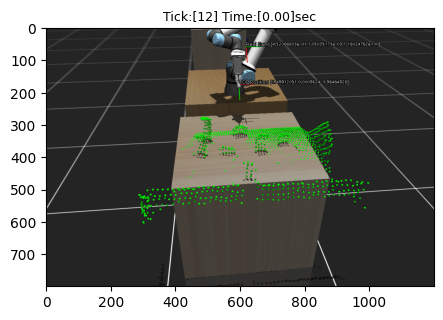

Done.


In [9]:
env.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=174.08,distance=2.76,elevation=-33,lookat=[0.1,0.05,0.16],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=False,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=False,jointlength=0.5,jointwidth=0.1,jointrgba=[0.2,0.6,0.8,0.6])
env.reset()
env.forward(q=joint_value, joint_idxs=env.idxs_forward)

tick = 0
while (env.get_sim_time() < 100.0) and env.is_viewer_alive():
    tick = tick + 1
    env.forward(q=joint_value, joint_idxs=env.idxs_forward)
    # Render
    p_tcp,R_tcp = env.get_pR_body(body_name='ur_tcp_link')
    p_cam,R_cam = env.get_pR_body(body_name='ur_camera_center')
    p_base,R_base = env.get_pR_body(body_name='ur_base')
    env.plot_T(p=p_tcp,R=R_tcp,PLOT_AXIS=True,axis_len=0.1,axis_width=0.0025,
               label=f'TCP Position: {p_tcp}')
    env.plot_T(p=T_cam[:3,3],R=T_cam[:3,:3],PLOT_AXIS=True,axis_len=0.1,axis_width=0.0025,
               label=f'Real Cam: {p_cam}')
        
    for p in xyz_img_world_rsz.reshape(-1,3):
        env.plot_sphere(p,r=0.005,rgba=[0,1,0,1])
    env.render()
    if env.loop_every(HZ=1) or (tick == 1):
        scene_img = env.grab_image()
# Plot an image
plt.figure(figsize=(5,4)); plt.imshow(scene_img)
plt.title("Tick:[%d] Time:[%.2f]sec"%(env.tick,env.get_sim_time()),fontsize=9)
plt.show()
# Close viewer
env.close_viewer()
print ("Done.")

In [108]:
import cv2

clicked_coordinates = []
source_obj_position = None
target_obj_position = None

def mouse_click(event, x, y, flags, param):
    global source_obj_position, target_obj_position
    # Source Object
    if event == cv2.EVENT_LBUTTONDOWN:
        source_obj_position = xyz_img_world[y, x]
        clicked_coordinates.append((x, y))
        print(f"Clicked at: x={x}, y={y}")
        idx = len(clicked_coordinates) - 1
        cv2.circle(rgb_image, (x, y), 5, (0, 0, 255), -1)
        cv2.putText(rgb_image, f"{idx}", (x-5, y-15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
        print(f"XYZ_WORLD: {xyz_img_world[y, x]}")

    # Target Object
    if event == cv2.EVENT_RBUTTONDOWN:
        target_obj_position = xyz_img_world[y, x]
        clicked_coordinates.append((x, y))
        print(f"Clicked at: x={x}, y={y}")
        idx = len(clicked_coordinates) - 1
        cv2.circle(rgb_image, (x, y), 5, (0, 255, 0), -1)
        cv2.putText(rgb_image, f"{idx}", (x-5, y-15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
        print(f"XYZ_WORLD: {xyz_img_world[y, x]}")

# Display the RGB image
cv2.namedWindow('Tag Detection Example', cv2.WINDOW_AUTOSIZE)
cv2.imshow("RGB Image", cv2.cvtColor(rgb_image, cv2.COLOR_RGB2BGR))
cv2.setMouseCallback("RGB Image", mouse_click)

while True:
    cv2.imshow("RGB Image", cv2.cvtColor(rgb_image, cv2.COLOR_RGB2BGR))
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q') or key == 27:
        break
# Cleanup
cv2.destroyAllWindows()

print(source_obj_position, target_obj_position)


Clicked at: x=749, y=516
XYZ_WORLD: [ 0.69733848 -0.0091457   0.76083026]
Clicked at: x=478, y=301
XYZ_WORLD: [0.91657288 0.16883915 0.69538077]
[ 0.69733848 -0.0091457   0.76083026] [0.91657288 0.16883915 0.69538077]


### Automate Pick-n-Place

In [111]:
def solve_ik_for_target_position(env, source_obj_position, target_obj_position, q_init):
    env.init_viewer(viewer_title='UR5e with RG2 gripper and objects', viewer_width=1200, viewer_height=800,
                    viewer_hide_menus=True)
    env.update_viewer(azimuth=124.08, distance=4.00, elevation=-33, lookat=[0.1, 0.05, 0.86],
                    VIS_TRANSPARENT=False, VIS_CONTACTPOINT=True,
                    contactwidth=0.05, contactheight=0.05, contactrgba=np.array([1, 0, 0, 1]),
                    VIS_JOINT=False, jointlength=0.2, jointwidth=0.05, jointrgba=[0.2, 0.6, 0.8, 1.0])
    env.reset()  # reset
    env.forward(q=q_init, joint_idxs=env.idxs_forward)

    if target_obj_position[0] > 0.9:
        Grasp_Mode = 'Forward'
        q_init_grasp = np.array([-6.41363032e-01, -1.15244289e+00,  2.70427236e+00, -1.55212554e+00,9.29296030e-01,  1.79191839e-04])
        # 1. Solve IK for the pre-grasping position
        p_base = env.get_p_body(body_name='ur_base')
        p_trgt = source_obj_position
        p_trgt[0] = source_obj_position[0] - 0.05
        p_trgt[2] = p_base[2] + 0.05
        R_trgt = rpy2r(np.radians([-180, 0, 90])) # Forward Grasping
        q_pre_grasp, ik_done = env.solve_ik_repel(
        body_name='ur_tcp_link',p_trgt=p_trgt,R_trgt=R_trgt,
        IK_P=True,IK_R=True, q_init=q_init_grasp,idxs_forward=env.idxs_forward, idxs_jacobian=env.idxs_jacobian,
        RESET=False,DO_RENDER=True,render_every=1,th=1*np.pi/180.0,err_th=1e-3, stepsize = 2.0, repulse=30, BREAK_TICK=2000)

        # 2. Solve IK for the grasping position
        p_trgt = source_obj_position
        p_trgt[2] = p_base[2] + 0.07
        R_trgt = rpy2r(np.radians([-180, 0, 90])) # Forward Grasping
        q_grasp, ik_done = env.solve_ik_repel(
        body_name='ur_tcp_link',p_trgt=p_trgt,R_trgt=R_trgt,
        IK_P=True,IK_R=True, q_init=q_pre_grasp,idxs_forward=env.idxs_forward, idxs_jacobian=env.idxs_jacobian,
        RESET=False,DO_RENDER=True,render_every=1,th=1*np.pi/180.0,err_th=1e-3, stepsize = 2.0, repulse=30, BREAK_TICK=2000)

        # 3. Solve IK for the lift-up position
        p_trgt = source_obj_position
        p_trgt[2] = p_base[2] + 0.25
        print(f"p_trgt: {p_trgt}")
        R_trgt = rpy2r(np.radians([-180, 0, 90])) # Forward Grasping
        q_liftup, ik_done = env.solve_ik_repel(
        body_name='ur_tcp_link',p_trgt=p_trgt,R_trgt=R_trgt,
        IK_P=True,IK_R=True, q_init=q_grasp,idxs_forward=env.idxs_forward, idxs_jacobian=env.idxs_jacobian,
        RESET=False,DO_RENDER=True,render_every=1,th=1*np.pi/180.0,err_th=1e-3, stepsize = 2.0, repulse=30, BREAK_TICK=2000)

        # 4. Solve IK for the place position
        p_trgt = target_obj_position
        p_trgt[0] = 0.75
        p_trgt[2] = 0.9
        R_trgt = rpy2r(np.radians([-180, 0, 90])) # Forward Grasping
        q_pre_place, ik_done = env.solve_ik_repel(
        body_name='ur_tcp_link',p_trgt=p_trgt,R_trgt=R_trgt,
        IK_P=True,IK_R=True, q_init=q_liftup,idxs_forward=env.idxs_forward, idxs_jacobian=env.idxs_jacobian,
        RESET=False,DO_RENDER=True,render_every=1,th=1*np.pi/180.0,err_th=1e-3, stepsize = 2.0, repulse=30, BREAK_TICK=2000)

        p_trgt[2] = 0.875
        R_trgt = rpy2r(np.radians([-180, 0, 90])) # Forward Grasping
        q_place, ik_done = env.solve_ik_repel(
        body_name='ur_tcp_link',p_trgt=p_trgt,R_trgt=R_trgt,
        IK_P=True,IK_R=True, q_init=q_pre_place,idxs_forward=env.idxs_forward, idxs_jacobian=env.idxs_jacobian,
        RESET=False,DO_RENDER=True,render_every=1,th=1*np.pi/180.0,err_th=1e-3, stepsize = 2.0, repulse=30, BREAK_TICK=2000)

        # Close viewer
        env.close_viewer()
        print("IK done.")
        return [q_init_grasp, q_pre_grasp, q_grasp, q_liftup, q_pre_place, q_place, q_liftup], Grasp_Mode

    else:
        Grasp_Mode = 'Up-Right'
        # 0. Solve IK for the init-grasp position
        p_base = env.get_p_body(body_name='ur_base')
        p_trgt = np.array([0.65, 0, 0.9])
        R_trgt = rpy2r(np.radians([-115, 0, 90])) # Up-Right Grasping
        q_init_grasp, ik_done = env.solve_ik_repel(
        body_name='ur_tcp_link',p_trgt=p_trgt,R_trgt=R_trgt,
        IK_P=True,IK_R=True, q_init=q_init,idxs_forward=env.idxs_forward, idxs_jacobian=env.idxs_jacobian,
        RESET=False,DO_RENDER=True,render_every=1,th=1*np.pi/180.0,err_th=1e-3, stepsize = 2.0, repulse=30, BREAK_TICK=2000)

        # 1. Solve IK for the pre-grasping position
        p_base = env.get_p_body(body_name='ur_base')
        p_trgt = source_obj_position
        p_trgt[0] = 0.75
        p_trgt[2] = 1.0
        R_trgt = rpy2r(np.radians([-90, 0, 90])) # Up-Right Grasping
        q_pre_grasp, ik_done = env.solve_ik_repel(
        body_name='ur_tcp_link',p_trgt=p_trgt,R_trgt=R_trgt,
        IK_P=True,IK_R=True, q_init=q_init_grasp,idxs_forward=env.idxs_forward, idxs_jacobian=env.idxs_jacobian,
        RESET=False,DO_RENDER=True,render_every=1,th=1*np.pi/180.0,err_th=1e-3, stepsize = 2.0, repulse=30, BREAK_TICK=2000)
        
        # 2. Solve IK for the grasping position
        p_trgt = source_obj_position
        p_trgt[2] = p_base[2] + 0.05
        R_trgt = rpy2r(np.radians([-90, 0, 90])) # Up-Right Grasping
        q_grasp, ik_done = env.solve_ik_repel(
        body_name='ur_tcp_link',p_trgt=p_trgt,R_trgt=R_trgt,
        IK_P=True,IK_R=True, q_init=q_pre_grasp,idxs_forward=env.idxs_forward, idxs_jacobian=env.idxs_jacobian,
        RESET=False,DO_RENDER=True,render_every=1,th=1*np.pi/180.0,err_th=1e-3, stepsize = 2.0, repulse=30, BREAK_TICK=2000)

        # 3. Solve IK for the lift-up position
        p_trgt = source_obj_position
        p_trgt[2] = p_base[2] + 0.25
        print(f"p_trgt: {p_trgt}")
        R_trgt = rpy2r(np.radians([-90, 0, 90])) # Up-Right Grasping
        q_liftup, ik_done = env.solve_ik_repel(
        body_name='ur_tcp_link',p_trgt=p_trgt,R_trgt=R_trgt,
        IK_P=True,IK_R=True, q_init=q_grasp,idxs_forward=env.idxs_forward, idxs_jacobian=env.idxs_jacobian,
        RESET=False,DO_RENDER=True,render_every=1,th=1*np.pi/180.0,err_th=1e-3, stepsize = 2.0, repulse=30, BREAK_TICK=2000)

        # 4. Solve IK for the place position
        p_trgt = target_obj_position
        p_trgt[2] = p_base[2] + 0.005
        R_trgt = rpy2r(np.radians([-90, 0, 90])) # Up-Right Grasping
        q_place, ik_done = env.solve_ik_repel(
        body_name='ur_tcp_link',p_trgt=p_trgt,R_trgt=R_trgt,
        IK_P=True,IK_R=True, q_init=q_liftup,idxs_forward=env.idxs_forward, idxs_jacobian=env.idxs_jacobian,
        RESET=False,DO_RENDER=True,render_every=1,th=1*np.pi/180.0,err_th=1e-3, stepsize = 2.0, repulse=30, BREAK_TICK=2000)

        # Close viewer
        env.close_viewer()
        print("IK done.")
        return [q_init_grasp, q_pre_grasp, q_grasp, q_liftup, q_place, q_pre_grasp], Grasp_Mode

target_obj_position = np.array([0.95, 0.0, 0.9])
q_init = np.array(joint_value)
q_res, Grasp_Mode = solve_ik_for_target_position(env, source_obj_position, target_obj_position, q_init)
q_array = np.array(q_res)
print("planned joint trajectory:",q_array)

MODE: window
Pressed ESC
Quitting.


Exception: GLFW window does not exist but you tried to render.

Joint trajectory ready. duration:[2.99]sec
Joint trajectory ready. duration:[3.58]sec
Joint trajectory ready. duration:[1.34]sec
Joint trajectory ready. duration:[1.73]sec
Joint trajectory ready. duration:[9.13]sec
Joint trajectory ready. duration:[1.42]sec
Joint trajectory ready. duration:[10.55]sec


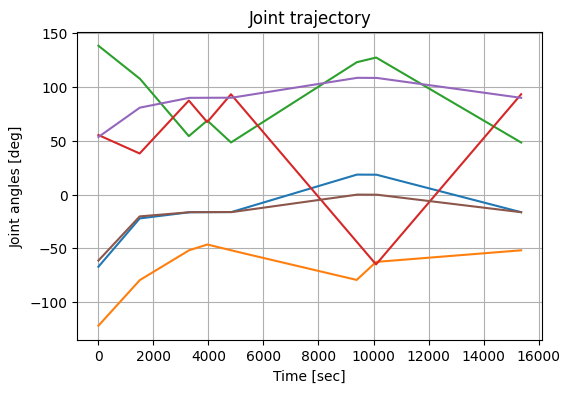

In [48]:
from models.utils.util import get_interp_const_vel_traj
from models.utils.grpp import GaussianRandomPathClass, kernel_levse

q_traj_list = []
times_list = []
q_array_flatten = np.concatenate([q_init.reshape(1,6) ,q_array.reshape(-1,6)])
for q_before, q_after in zip(q_array_flatten[:-1], q_array_flatten[1:]):
    q_array_ = np.vstack([q_before, q_after])
    times, q_traj = get_interp_const_vel_traj(q_array_, vel=np.radians(15), HZ=env.HZ)
    print("Joint trajectory ready. duration:[%.2f]sec" % (times[-1]))
    q_traj_list.append(q_traj)
    times_list.append(times)
q_traj = np.concatenate(q_traj_list)

plt.figure(figsize=(6, 4))
plt.plot(np.degrees(q_traj))
plt.xlabel('Time [sec]')
plt.ylabel('Joint angles [deg]')
plt.grid(True)
plt.title("Joint trajectory")
plt.show()

MODE: window


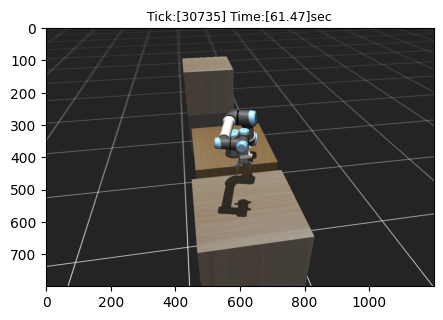

Done.


In [50]:
# Gripper openning should be done by calling step()
env.init_viewer(viewer_title='UR5e with RG2 gripper and objects',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=124.08,distance=4.00,elevation=-33,lookat=[0.1,0.05,0.86],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=False,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=False,jointlength=0.2,jointwidth=0.05,jointrgba=[0.2,0.6,0.8,1.0])

env.reset() # reset
env.forward(q=joint_value, joint_idxs=env.idxs_forward)
env.update_viewer(azimuth=170,distance=2.5,lookat=env.get_p_body(body_name='ur_tcp_link'))

OPEN = True
CLOSE = False

if Grasp_Mode == 'Forward':
    grasp_list = [OPEN, OPEN, CLOSE, CLOSE, CLOSE, CLOSE, OPEN]
elif Grasp_Mode == 'Up-Right':
    grasp_list = [OPEN, OPEN, CLOSE, CLOSE, CLOSE, OPEN]

for i,q_traj_ in enumerate(q_traj_list):
    for q_ in q_traj_:
        if not env.is_viewer_alive():
            break
        start_time = env.get_sim_time()
        env.step(ctrl=q_,ctrl_idxs=env.idxs_step)
        env.step(ctrl=float(grasp_list[i%6]),ctrl_idxs=6)
        env.render(render_every=10)
        if env.loop_every(HZ=1) or (tick == 1):
            scene_img = env.grab_image()
        if env.loop_every(HZ=10) or (tick == 1):
            for p in xyz_img_world_rsz.reshape(-1,3):
                env.plot_sphere(p,r=0.005,rgba=[0,1,0,1])

# Plot an image
plt.figure(figsize=(5,4)); plt.imshow(scene_img)
plt.title("Tick:[%d] Time:[%.2f]sec"%(env.tick,env.get_sim_time()),fontsize=9)
plt.show()
# Close viewer
env.close_viewer()
print ("Done.")

In [51]:
joint_value = np.array([-1.17291159, -2.12601153,  2.41418378,  0.96829606,  0.93633773, -1.06900867])
env.forward(q=joint_value, joint_idxs=env.idxs_forward)
print(env.get_p_body('ur_tcp_link'))

[ 4.99093237e-01 -3.25960196e-04  9.65033573e-01]


In [52]:
# # Set to Initial Pose.
real_robot.move_capture_pose(init_q=joint_value);time.sleep(1)
# real_robot.main(joint_list=q_traj); time.sleep(1) # Moving time

Waiting for server...
Connected to server
Capture Pose is Entered


### Reset to Init capture pose

In [53]:
import copy

# Reset to Init capture pose
q = copy.deepcopy(joint_value)
q_traj = JointTrajectory()

point = JointTrajectoryPoint()
point.positions = q
point.velocities = [0 for _ in range(6)]
point.time_from_start = rospy.Duration.from_sec(3.0)

q_traj.points.append(point)
real_robot.execute_arm_speed(q_traj, speed_limit=1.0)
real_robot.client.wait_for_result()

resetTool(graspclient)
openGrasp(force=200, width=1000, graspclient=graspclient)
time.sleep(1)

Waiting for server...
Connected to server
[array([-1.17289192, -2.12601151,  2.41420061,  0.96827857,  0.93635964,
       -1.06901962]), array([-1.17291159, -2.12601153,  2.41418378,  0.96829606,  0.93633773,
       -1.06900867])]
[-1.17291159 -2.12601153  2.41418378  0.96829606  0.93633773 -1.06900867] [-1.17289192 -2.12601151  2.41420061  0.96827857  0.93635964 -1.06901962]
diff_q:[-1.96711871e-05 -1.91114293e-08 -1.68279303e-05  1.74892339e-05
 -2.19139362e-05  1.09496186e-05]
diff_time:3.0
1.323347293271829e-05
Finish plan
Tool reseting


#### Move Trajectory

In [58]:
unit_time_base = 1.0
track_time = 0

q_curr = rospy.wait_for_message("joint_states", JointState).position
env.forward(q=q_curr,joint_idxs=env.idxs_forward)
x_before = env.get_p_body("ur_tcp_link")
q_before = np.array(q_curr)

speed_limit = 0.3  # speed limit of EE velocity
q_speed_limit = 3.0 # speed limit of joint velocity
resetTool(graspclient)
openGrasp(force=200, width=1000, graspclient=graspclient)
time.sleep(1)

if Grasp_Mode == 'Forward':
    grasp_list = ['open', 'open', 'close', 'close', 'close', 'open', 'open']
elif Grasp_Mode == 'Up-Right':
    grasp_list = ['open', 'open', 'close', 'close', 'close', 'open']
    
q_array_flatten = q_array.reshape(-1,6)
for i, qs in enumerate(q_array_flatten):    
    q_traj = JointTrajectory()
    
    env.forward(q=qs,joint_idxs=env.idxs_forward)
    x_curr = env.get_p_body("ur_tcp_link")
    delta_x = np.linalg.norm(x_curr - x_before)
    delta_q = np.linalg.norm(qs - q_before)
    
    unit_time = max(delta_q/q_speed_limit,max(delta_x/(speed_limit), unit_time_base))
    print(f"unit_time: {unit_time}")
    
    track_time = track_time + unit_time
    point = JointTrajectoryPoint()
    point.positions = qs
    point.velocities = [0 for _ in range(6)]
    point.time_from_start = rospy.Duration.from_sec(track_time + 2.0)
    q_traj.points.append(point)
    
    x_before = x_curr

    real_robot.execute_arm_speed(q_traj, speed_limit=1.6)
    real_robot.client.wait_for_result()
    time.sleep(0.5)

    if grasp_list[i%len(grasp_list)] is None:
        continue
    elif grasp_list[i%len(grasp_list)].lower() == 'open':
        openGrasp(force=200, width=1000, graspclient=graspclient)
    elif grasp_list[i%len(grasp_list)].lower() == 'close':
        closeGrasp(force=200, width=400, graspclient=graspclient)
    else:
        raise ValueError('grasp_list must be None, open, or close')

# Set to Initial Pose.
real_robot.move_capture_pose(init_q=joint_value);time.sleep(1)

Tool reseting
unit_time: 1.0d
Waiting for server...
Connected to server
[array([-1.17454559, -2.12826838,  2.41705209,  0.96710603,  0.93513799,
       -1.07044632]), array([-0.38704115, -1.38964304,  1.88619206,  0.66658167,  1.41049591,
       -0.35389399])]
[-0.38704115 -1.38964304  1.88619206  0.66658167  1.41049591 -0.35389399] [-1.17454559 -2.12826838  2.41705209  0.96710603  0.93513799 -1.07044632]
diff_q:[ 0.78750444  0.73862534 -0.53086003 -0.30052436  0.47535793  0.71655233]
diff_time:3.0
0.5030209066278578
Finish plan
unit_time: 1.0
Waiting for server...
Connected to server
[array([-0.38566906, -1.38835617,  1.88529665,  0.66608874,  1.41132617,
       -0.35265524]), array([-0.28567079, -0.9046583 ,  0.94888245,  1.52645323,  1.57076481,
       -0.28567558])]
[-0.28567079 -0.9046583   0.94888245  1.52645323  1.57076481 -0.28567558] [-0.38566906 -1.38835617  1.88529665  0.66608874  1.41132617 -0.35265524]
diff_q:[ 0.09999827  0.48369787 -0.9364142   0.86036449  0.15943864  0.

In [57]:
Grasp_Mode

'Forward'

In [ ]:
import json
import pyrealsense2 as rs
import matplotlib.pyplot as plt
import numpy as np
import mujoco
import mujoco_viewer
import cv2,os
import sys

# Load camera settings
jsonObj = json.load(open("./cam_setting.json"))
stream_width = int(jsonObj["viewer"]['stream-width'])
stream_height = int(jsonObj["viewer"]['stream-height'])
stream_fps = int(jsonObj["viewer"]['stream-fps'])

# Configure pipeline
pipe = rs.pipeline()
cfg = rs.config()
cfg.enable_stream(rs.stream.depth, stream_width, stream_height, rs.format.z16, stream_fps)
cfg.enable_stream(rs.stream.color, stream_width, stream_height, rs.format.bgr8, stream_fps)
pipe.start(cfg)
profile = pipe.get_active_profile()
# intrinsics = profile.get_stream(rs.stream.depth).as_video_stream_profile().get_intrinsics()
intrinsics = profile.get_stream(rs.stream.color).as_video_stream_profile().get_intrinsics()

# Create the intrinsic matrix
K = np.array([[intrinsics.fx, 0, intrinsics.ppx],
              [0, intrinsics.fy, intrinsics.ppy],
              [0, 0, 1]])
camera_info = [intrinsics.fx, intrinsics.fy, intrinsics.ppx, intrinsics.ppy]
print(f"Intrinsic matrix: \n{K}")

# Capture frames
for _ in range(100):
    pipe.wait_for_frames()

# Retrieve frames
frameset = pipe.wait_for_frames()
aligned_frames = rs.align(rs.stream.color).process(frameset)
depth_frame = aligned_frames.get_depth_frame()
color_frame = aligned_frames.get_color_frame()

# Apply depth filters
spatial = rs.spatial_filter()
spatial.set_option(rs.option.holes_fill, 3)
hole_filling = rs.hole_filling_filter()

# Get RGBD images
depth_image = np.asanyarray(hole_filling.process(spatial.process(depth_frame)).get_data())
depth_image_unfilled = np.asanyarray(depth_frame.get_data())
rgb_image = np.asanyarray(color_frame.get_data())
rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)
# Clip depth image
depth_scale = pipe.get_active_profile().get_device().first_depth_sensor().get_depth_scale()
clipping_distance_in_meters = 2
clipping_distance = clipping_distance_in_meters / depth_scale
depth_unfilled_clipped = np.where((depth_image_unfilled > clipping_distance) | (depth_image_unfilled <= 0), 0, depth_image_unfilled)
depth_clipped = np.where((depth_image > clipping_distance) | (depth_image <= 0), 0, depth_image)
# Cleanup
pipe.stop()

# Display images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Color Image")
# plt.imshow(depth_unfilled_clipped, cmap='gray')
plt.imshow(rgb_image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Clipped Filled Depth Image")
plt.imshow(depth_clipped, cmap='gray')
plt.colorbar()
plt.axis('off')
plt.show()

In [ ]:
import json
import pyrealsense2 as rs
import matplotlib.pyplot as plt
import numpy as np
import mujoco
import mujoco_viewer
import cv2,os
import sys

# Load camera settings
jsonObj = json.load(open("./cam_setting.json"))
stream_width = int(jsonObj["viewer"]['stream-width'])
stream_height = int(jsonObj["viewer"]['stream-height'])
stream_fps = int(jsonObj["viewer"]['stream-fps'])

# Configure pipeline
pipe = rs.pipeline()
cfg = rs.config()
cfg.enable_stream(rs.stream.depth, stream_width, stream_height, rs.format.z16, stream_fps)
cfg.enable_stream(rs.stream.color, stream_width, stream_height, rs.format.bgr8, stream_fps)
pipe.start(cfg)
profile = pipe.get_active_profile()
# intrinsics = profile.get_stream(rs.stream.depth).as_video_stream_profile().get_intrinsics()
intrinsics = profile.get_stream(rs.stream.color).as_video_stream_profile().get_intrinsics()

# Create the intrinsic matrix
K = np.array([[intrinsics.fx, 0, intrinsics.ppx],
              [0, intrinsics.fy, intrinsics.ppy],
              [0, 0, 1]])
camera_info = [intrinsics.fx, intrinsics.fy, intrinsics.ppx, intrinsics.ppy]
print(f"Intrinsic matrix: \n{K}")

# Capture frames
for _ in range(100):
    pipe.wait_for_frames()

# Retrieve frames
frameset = pipe.wait_for_frames()
aligned_frames = rs.align(rs.stream.color).process(frameset)
depth_frame = aligned_frames.get_depth_frame()
color_frame = aligned_frames.get_color_frame()

# Apply depth filters
spatial = rs.spatial_filter()
spatial.set_option(rs.option.holes_fill, 3)
hole_filling = rs.hole_filling_filter()

# Get RGBD images
depth_image = np.asanyarray(hole_filling.process(spatial.process(depth_frame)).get_data())
depth_image_unfilled = np.asanyarray(depth_frame.get_data())
rgb_image = np.asanyarray(color_frame.get_data())
rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)
# Clip depth image
depth_scale = pipe.get_active_profile().get_device().first_depth_sensor().get_depth_scale()
clipping_distance_in_meters = 2
clipping_distance = clipping_distance_in_meters / depth_scale
depth_unfilled_clipped = np.where((depth_image_unfilled > clipping_distance) | (depth_image_unfilled <= 0), 0, depth_image_unfilled)
depth_clipped = np.where((depth_image > clipping_distance) | (depth_image <= 0), 0, depth_image)
# Cleanup
pipe.stop()

# Display images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Color Image")
# plt.imshow(depth_unfilled_clipped, cmap='gray')
plt.imshow(rgb_image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Clipped Filled Depth Image")
plt.imshow(depth_clipped, cmap='gray')
plt.colorbar()
plt.axis('off')
plt.show()